<a href="https://colab.research.google.com/github/kszymon/convnet/blob/main/projects%20/01_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Konwolucyjne Sieci Neuronowe - Dogs vs. Cats

 > Projekt polega na przyjrzeniu się sieciom konwolucyjnym (Convolutional Neural Network - CNN) i próbie zastosownia tych sieci w zagadnieniach klasyfikacji obrazu. Pokażemy jak postępować w przypadku  niewielkiego zbioru danych treningowych i jakie techniki zastosować w celu optymalizacji takich modeli.

 > W odróżnieniu od sieci gęstych, które uczą się cech globalnie, sieci konwolucyjne uczą się lokalnych wzorców. Innymi słowy wzorce rozpoznawane przez sieć kownolucyjną są niezależne od przesunięcia, co charakteryzuje sieci CNN bardzo dużą wydajnością.

 > Kolejną zaletą sieci CNN jest możliwość uczenia przestrzennej hierarchii wzorców. Pierwsze warstwy uczą się małych lokalnych wzorców, takich jak krawędzie, zaś klolejne warstwy będą uczyły się większych struktur składających się z elementów rozpoznanych przez początkowe warstwy.

 > Do utworzenia projektu wykorzystano narzędzie dostarczane przez firmę Google, Google Colab, które jest rozszerzoną nakładką na Jupyter Notebook pozwalającą uruchamiać notebooki na procesorze graficznym GPU (Graphics Processing Unit).

### Czyszczenie katalogu roboczego

> **Tip**: Wpisując na początku komórki polecenie `%%bash` jesteśmy w stanie wykonywać polecenia bashowe na systemie goszczącym naszą instancję notebook'a. Na początek wyczyścimy nasz katalog roboczy.

In [2]:
%%bash
rm -rf /content/*

### Zaimportowanie wymaganych bibliotek

In [3]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

### Pobranie danych
Dane pobierzemy z bucketu S3. S3 jest to usługa storage w chmurze Amazona.

Nazwa bucketu to: `ml-repository-krakers`.

Spakowany plik `dogs-vs-cats.zip` ma nieco ponad 812 MB i jest przechowywany w regionie UE (Ireland).

In [4]:
%%bash
pwd
wget --output-document=cats_and_dogs.zip --quiet https://ml-repository-krakers.s3-eu-west-1.amazonaws.com/kaggle+/cats_and_dogs/dogs-vs-cats.zip
ls

/content
cats_and_dogs.zip


### Wypakowanie danych

In [5]:
%%bash
unzip cats_and_dogs.zip
# rm -rf cats_and_dogs.zip

rm -rf sampleSubmission.csv

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle_original_data/train

unzip -q /content/test1.zip
# rm -rf test1.zip
# rm -rf cats_and_dogs.zip
ls

Archive:  cats_and_dogs.zip
  inflating: sampleSubmission.csv    
  inflating: train.zip               
  inflating: test1.zip               
cats_and_dogs.zip
kaggle_original_data
test1
test1.zip


### Zdefiniowanie użytecznych funkcji

In [6]:
def make_accuracy_plot(history):
    """
    Funkcja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym
    i walidacyjnym.
    """
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Dokładność trenowania', marker='o')
    plt.plot(epochs, val_acc, label='Dokładność walidacji', marker='o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Dokładność')
    plt.show()

def make_loss_plot(history):
    """
    Funkcja zwraca wykres straty (loss) modelu na zbiorze treningowym
    i walidacyjnym.
    """
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Strata trenowania', marker='o')
    plt.plot(epochs, val_loss, label='Strata walidacji', marker='o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    plt.show()

def display_augmented_images(directory, index):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(20, 14))
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

### Przygotowanie katologów

Nasze dane będą znajdować się w katalogu:

> `/content/cats_and_dogs`

Podzielimy ten katalog na trzy podkatalogi:
 * train
 * valid
 * test

W zbiorze treningowym odłożymy 2000 próbek (1000 zdjęć psów i 1000 zdjęć kotów), do zbioru walidacyjnego trafi 1000 próbek (500 zdjęć psów i 500 zdjęć kotów), zaś do zbioru testowego ostatnie 1000 próbek (500 zdjęć psów i 500 zdjęć kotów).

In [7]:
# ścieżka do oryginalnego zbioru
original_dataset_dir = '/content/kaggle_original_data'
# katalog, w którym umieścimy nasze dane
base_dir = '/content/cats_and_dogs'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(base_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(base_dir, 'test')      # katalog zbioru testowego

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

dirs = [train_cats_dir, train_dogs_dir, valid_cats_dir, valid_dogs_dir, test_cats_dir, test_dogs_dir]

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [8]:
# rozdzielamy zdjęcia kotów
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# rozdzielamy zdjęcia psów
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

### Sprawdzenie poprawności podziału

In [9]:
print('Liczba kotów - zbiór treningowy', len(os.listdir(train_cats_dir)))
print('Liczba kotów - zbiór walidacyjny', len(os.listdir(valid_cats_dir)))
print('Liczba kotów - zbiór testowy', len(os.listdir(test_cats_dir)))

print('Liczba psów - zbiór treningowy', len(os.listdir(train_dogs_dir)))
print('Liczba psów - zbiór walidacyjny', len(os.listdir(valid_dogs_dir)))
print('Liczba psów - zbiór testowy', len(os.listdir(test_dogs_dir)))

Liczba kotów - zbiór treningowy 1000
Liczba kotów - zbiór walidacyjny 500
Liczba kotów - zbiór testowy 500
Liczba psów - zbiór treningowy 1000
Liczba psów - zbiór walidacyjny 500
Liczba psów - zbiór testowy 500


### Przyjrzenie się przykładowym obrazkom - koty
> Tip: W celu wybrania innego indeksu obrazka użyj suwaka po prawej stronie.

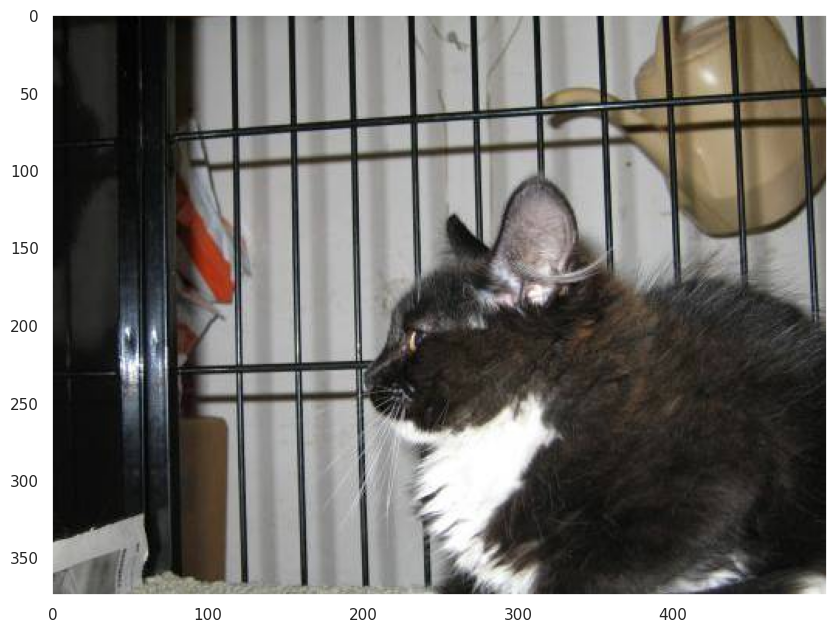

In [10]:
#@title Wybierz indeks przykładowego zdjęcia kota:
from keras.preprocessing import image

index = 231 #@param {type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/cats/cat.' + str(index) +'.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.grid(False)

### Przyjrzenie się przykładowym obrazkom - psy
> Tip: W celu wybrania innego indeksu obrazka użyj suwaka po prawej stronie.

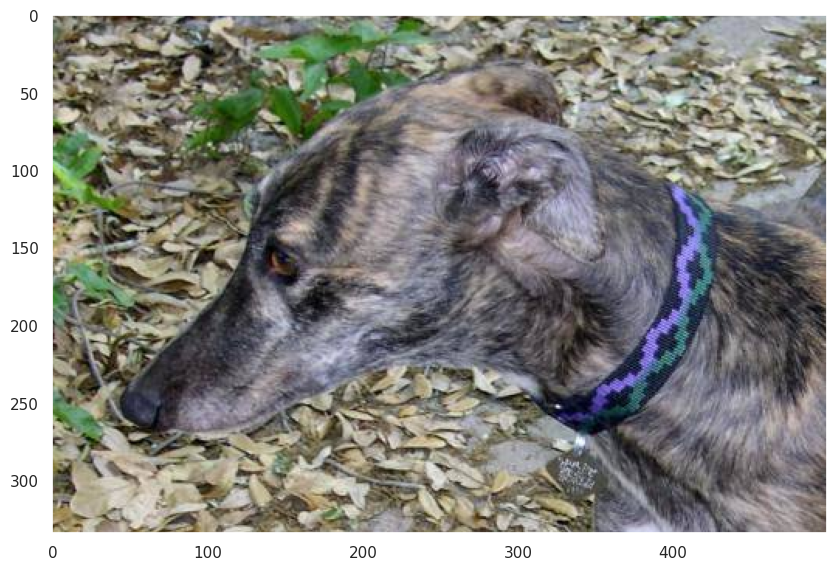

In [11]:
#@title Wybierz indeks przykładowego zdjęcia psa:
index = 121 #@param {type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/dogs/dog.' + str(index) +'.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)

### Budowa modelu

> Do budowy modelu wykorzystamy klasę `Sequential` biblioteki `Keras`. Pozwala ona dosyć wygodnie budować model niejako definiując kolejne warstwy tak, jakbyśmy układali je na stosie. Omówimy sobie krótko poszczególne warstwy.

> Warstwa Conv2D jest warstwą konwolucji, w której należy podać minimum trzy parametry: liczbę filtrów, dzięki którym będą wydobywane cechy, rozmiar jądra (wielkość okna konwolucji, zwyczajowo 3x3 lub 5x5) oraz fukncję aktywacji (najczęściej stosowana funkcja `relu`). Dodatkowo w pierwszej warstwie należy określić parametr `input_shape`, który przyjmuje rozmiar danych wejściowych. W naszym przypadku `(150, 150, 3)`. Pierwsze dwie wartości określają szerokość i wysokość obrazka, trzeci natomiast głębię kolorów, w tym przypadku 3.

> Warstwa MaxPooling2D  jest operacją skalowania. W dużym uproszczeniu polega na redukcji wymiarowości przechodząc po obrazie oknami ekstrakcji, które zwracają maksymalną zaobserwowaną wartość w danym oknie (zwykle rozmiar okna 2x2, przy kroku przesunięcia równym 2) pomagając tym samym zmniejszyć rozmiar danych wejściowych do kolejnej warstwy o połowę, co znacząco przyśpiesza proces uczenia.

> Warstwa Flatten wypłaszcza nam nasze dane w celu połączenia ich warstwami gęstymi pod koniec budowy modelu. Ostatnią funkcją aktywacji będzie funkcja `sigmoid`, która zwróci nam prawdobodobieństwa przynależności obrazka do poszczególnej klasy.

In [12]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Dzięki metodzie `summary()` możemy wyświetlić szczegóły modelu. Model ma do wyuczenia w tym przypadku 3,453,121 parametrów, składa się z 11 warstw (4 warstwy konwolucyjne, 4 warstwy MaxPooling, 1 warstwa Flatten i dwie warstwy gęste)

### Kompilacja modelu

Wyokrzystamy dosyć powszechny optymalizator `RMSProp` przy funkcji straty entropii krzyżowej i metryce dokładności.

In [13]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

### Przetworzenie danych do modelu

Ponieważ nasze dane są nieustandaryzowane (różne rozmiary obrazów) musimy jes przetworzyć, tak aby były przedstawione w formie tensorów wartości zmiennoprzecinkowych (float). Nasze dane są obecnie w postaci plików JPG. W procesie obróbki danych pomoże nam wbudowana w `Keras` klasa `ImageDataGenerator`.  Wszystkie obrazy ze zbioru treningowego i walidacyjnego przeskalujemy do rozmiaru 150x150 pikseli.

#### W skrócie, co zrobimy?:
* wczytamy pliki w formacie JPG
* zdekodujemy format JPG do siatki pikseli w formacie RGB
* zapiszemy dane w formacie tensorów liczb zmiennoprzecinkowych
* przeskalujemy wartości pikseli do zakresu [0, 1] (sieci neuronowe lepiej radzą sobie z małymi wartościami wejściowymi)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Sprawdzenie poprawności kształtu danych treningowych

In [15]:
for data_batch, labels_batch in train_generator:
    print('Kształt danych wsadowych:', data_batch.shape)
    print('Kształt etykiet danych wsadowych:', labels_batch.shape)
    break

Kształt danych wsadowych: (20, 150, 150, 3)
Kształt etykiet danych wsadowych: (20,)


### Dopasowanie modelu

W celu przeprowadzenia trenowania na generatorze należy użyć metody `fit`. Wytrenowany model zapiszemy do pliku `cats_and_dogs_small_1.h5`.

In [16]:
import time

tic = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50)

toc = time.time()
print('Czas przetwarzania: {}'.format(toc - tic))
model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4941 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5480 - loss: 0.6825 - val_accuracy: 0.5530 - val_loss: 0.6702
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5795 - loss: 0.6688 - val_accuracy: 0.5560 - val_loss: 0.6642
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6320 - loss: 0.6449 - val_accuracy: 0.6460 - val_loss: 0.6344
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6520 - loss: 0.6256 - val_accuracy: 0.6360 - val_loss: 0.6234
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6796 - loss: 0.5922 - val_accuracy: 0.6500 - val_loss: 0.6223
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6984 - loss: 0.5758 - val_accuracy: 0.6600 - val_loss: 0.6051
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.7174 - loss: 0.5413 - val_

Czas przetwarzania: 221.4512448310852


### Wykres dokładności trenowania i walidacji

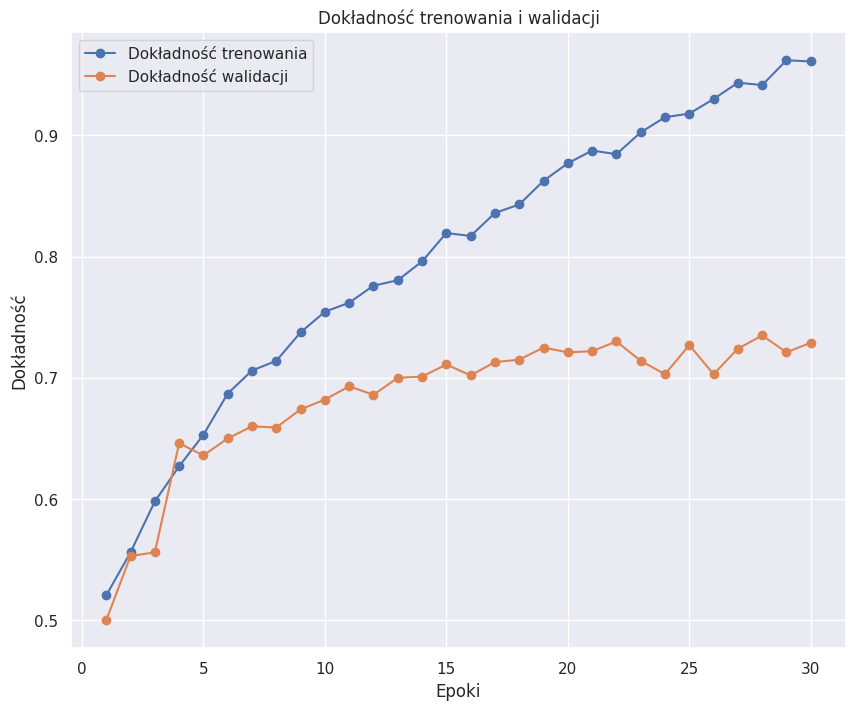

In [17]:
make_accuracy_plot(history)

### Wykres straty trenowania i walidacji

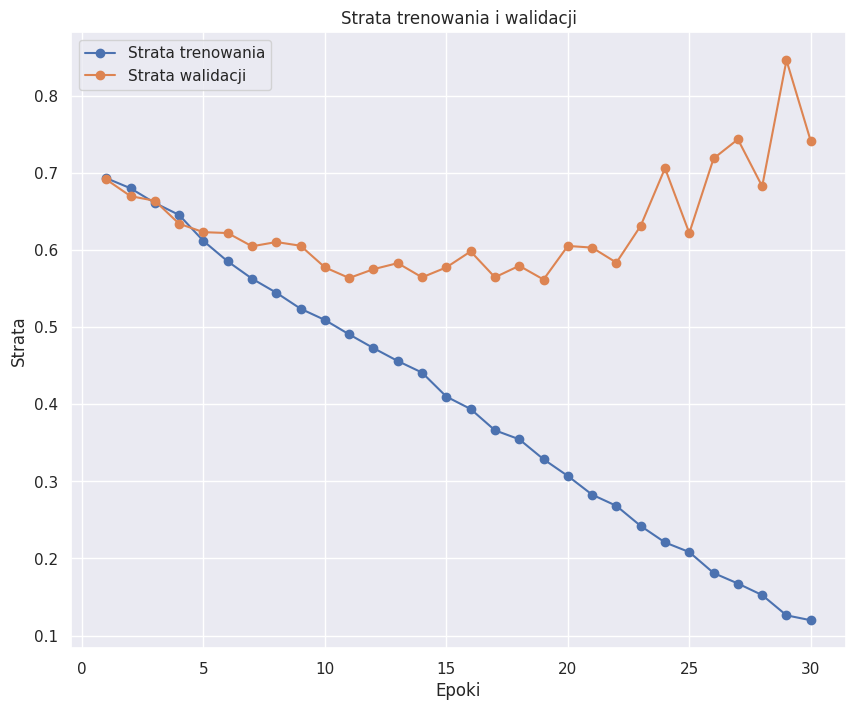

In [18]:
make_loss_plot(history)

Jak widać nasz model uległ przetrenowaniu - nadmiernemu dopasowaniu (overfitting) już po ok. 10 epokach uzyskując dokładność na poziomie ok. 73%. Nie jest to zadowalajcy wynik i postaramy się przy użyciu różnych technik poprawić nasz model. Potraktujemy ten wynik jako nasz benchmark do kolejnych modeli.

## Augmentacja Danych

Pierwszą z technik, którą sobie omówimy jest technika augmentacji danych. Jest ona szczególnie przydatna  w przypadkach niewystarczającej ilości danych treningowych. Polega ona na różnych przekształceniach naszych  danych wejściowych poprzez takie operacje jak przycinanie, obrót czy powiększanie w celu wygenerowania nowych danych wejściowych (nowych obrazków).

Więcej na temat klasy `ImageDataGenerator` i jej parametrów na stronie [dokumentacji biblioteki Keras](https://keras.io/preprocessing/image/#imagedatagenerator-class).

In [19]:
datagen = ImageDataGenerator(rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
                            width_shift_range=0.2,  # pionowe przekształcenia obrazu
                            height_shift_range=0.2, # poziome przekształcenia obrazu
                            shear_range=0.2,        # zares losowego przycianania obrazu
                            zoom_range=0.2,         # zakres losowego przybliżania obrazu
                            horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
                            fill_mode='nearest')    # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń

### Wyświetlenie kilku przykładów augmentacji - koty

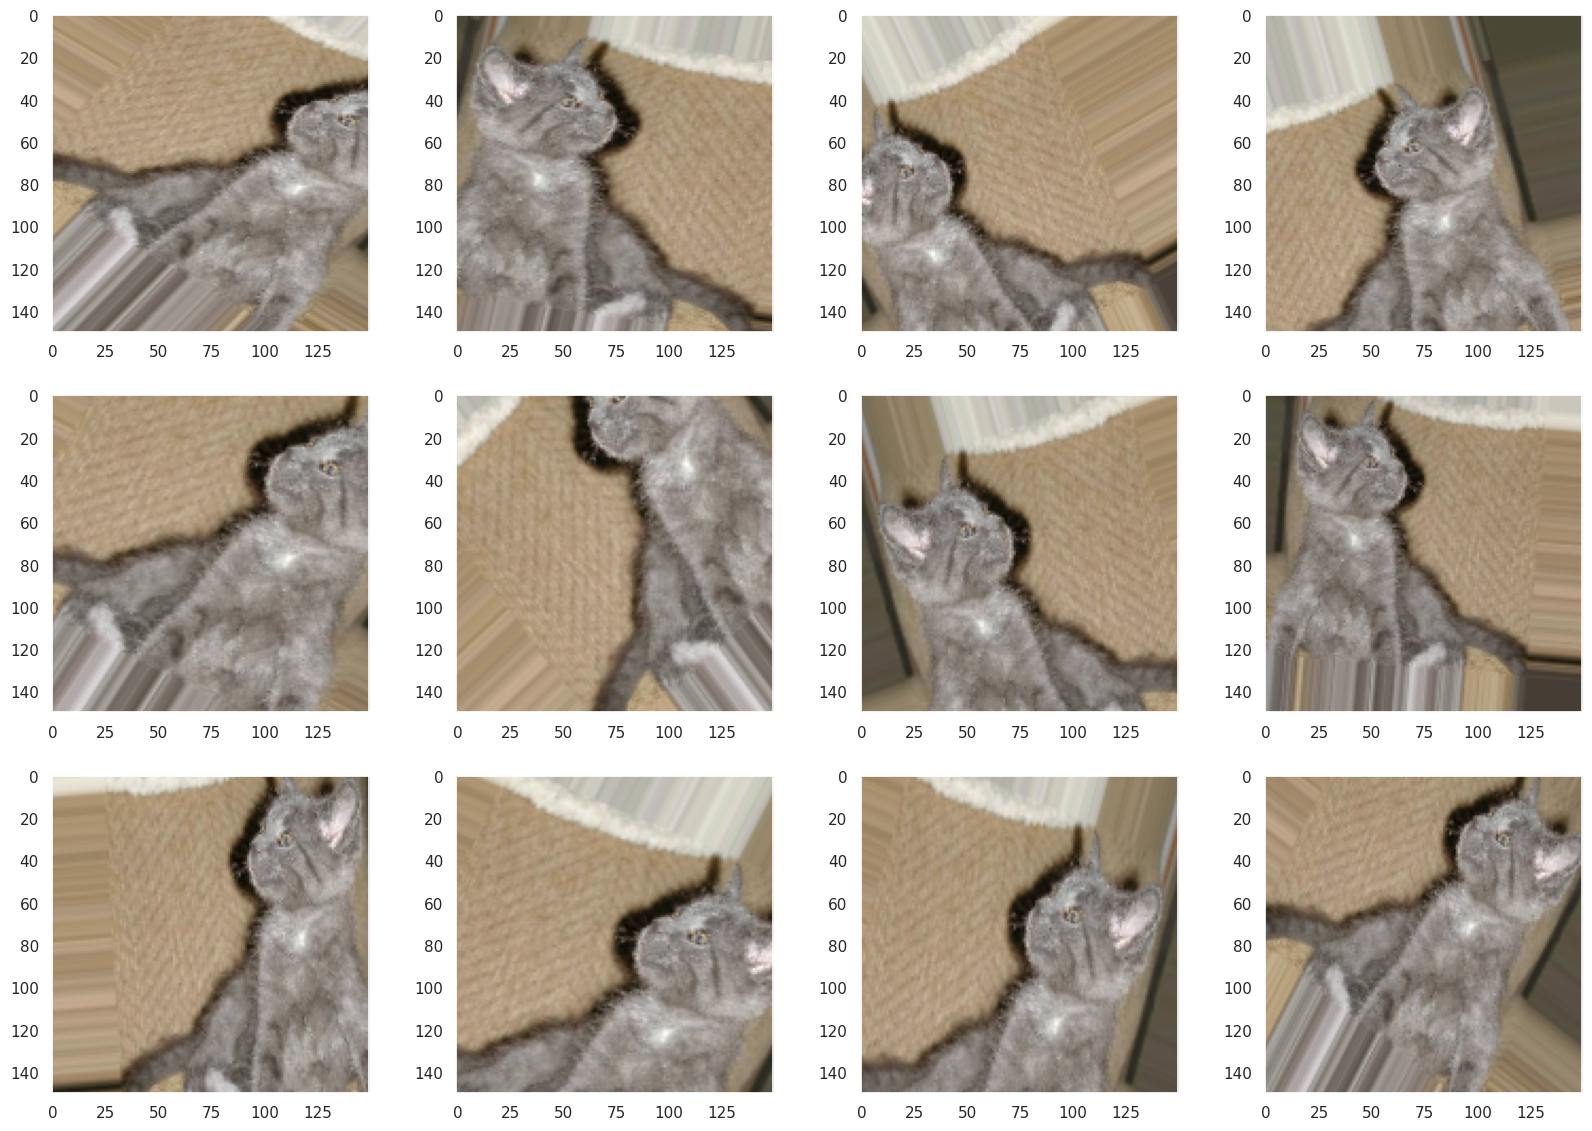

In [20]:
#@title Wybierz index obrazka w celu jego eksploracji
from keras.preprocessing import image

index = 323 #@param {type:'slider', min:0, max:999}
display_augmented_images(train_cats_dir, index)

### Wyświetlenie kliku przykładów augmentacji - psy

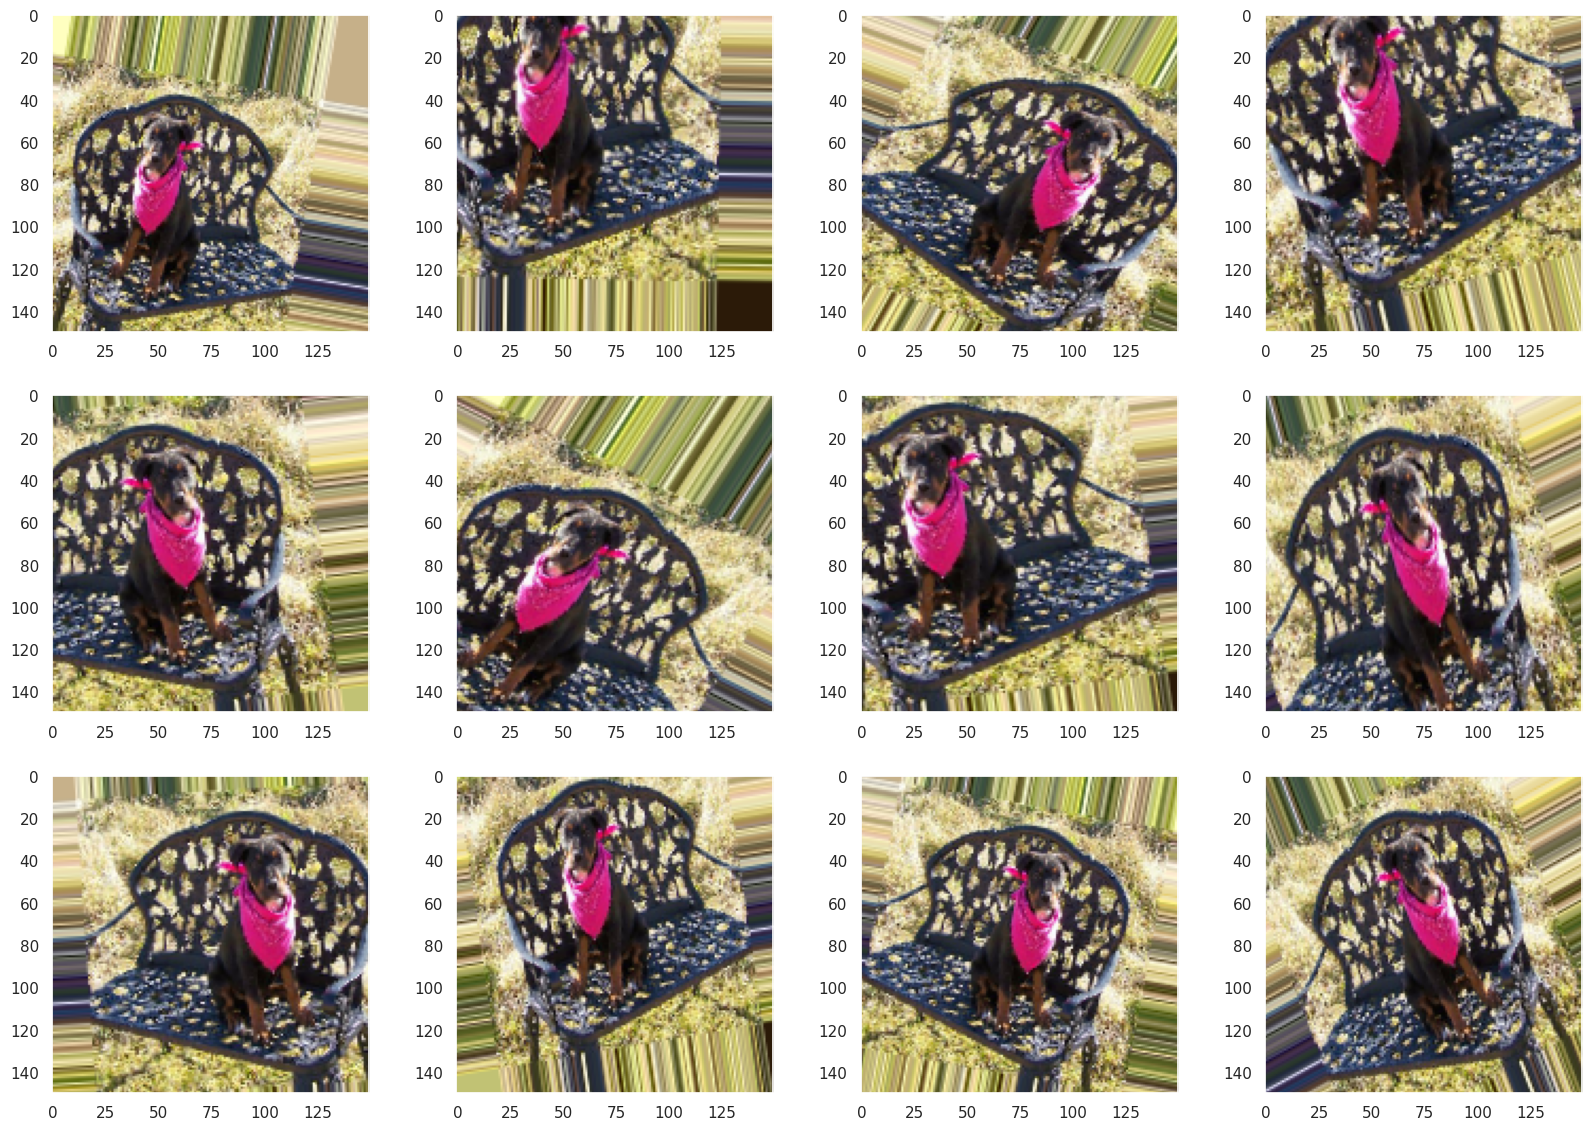

In [21]:
index = 333 #@param {type:'slider', min:0, max:999}
display_augmented_images(train_dogs_dir, index)

### Trenowanie konwolucyjnej sieci neuronowej z wykorzystaniem obrazów wygenerowanych za pomocą augmentacji danych

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# nie modyfikujemy danych walidacyjnych!!!
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Trenowanie modelu

In [24]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,    # 100
                    validation_data=valid_generator,
                    validation_steps=50)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.4967 - loss: 0.9615 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.5180 - loss: 0.6964 - val_accuracy: 0.5020 - val_loss: 0.6917
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.5266 - loss: 0.6916 - val_accuracy: 0.5990 - val_loss: 0.6843
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.5376 - loss: 0.6905 - val_accuracy: 0.5500 - val_loss: 0.6754
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.5738 - loss: 0.6737 - val_accuracy: 0.5090 - val_loss: 0.7352
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.5945 - loss: 0.6686 - val_accuracy: 0.6190 - val_loss: 0.6389
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.6004 - loss: 0.6477 - val_accuracy: 0.5220 - val_loss: 0.7283
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.6250 -

### Zapisanie modelu do pliku

In [25]:
model.save('cats_and_dogs_small_2.h5')

### Wykres dokładności trenowania i walidacji

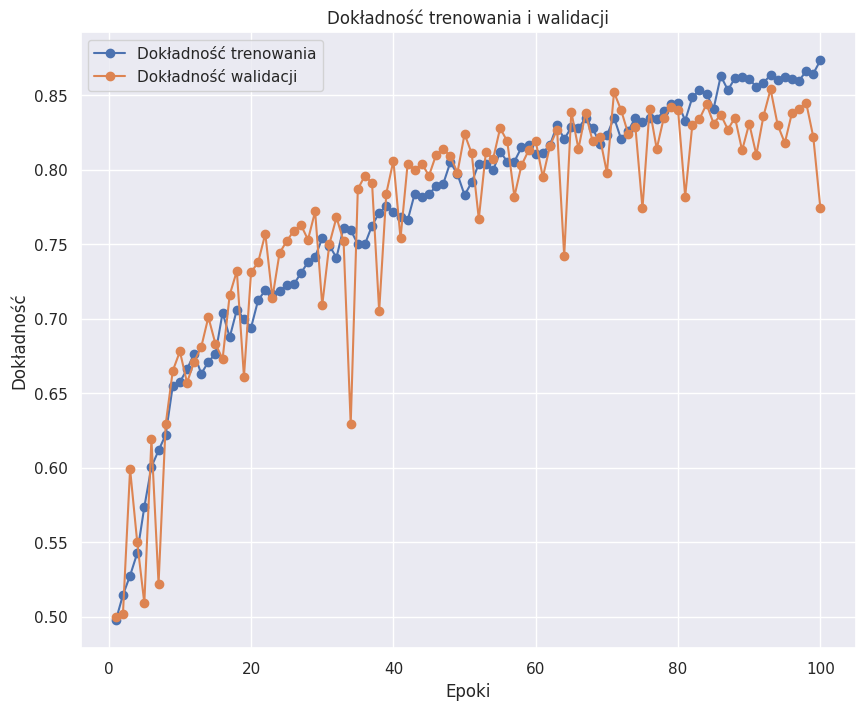

In [26]:
make_accuracy_plot(history)

Po zastosowaniu techniki augmentacji danych model znacząco poprawił swoją moc. Dokładność modelu oscyluje w granicach 82-84% co już jest całkiem dobrym wynikiem. Patrząc na funkcję straty sam model ulega przeuczeniu po około 40 epokach. Należy zwrócić uwagę na niestabilność miary dokładności na danych walidacyjnych. Zajmiemy się tym w kolejnych krokach.

### Transfer Learning - korzystanie z uprzednio przetrenowango modelu

Transfer Learning polega na wykorzystaniu już przetrenowenego modelu, zwykle na bardzo dużym zbiorze wejściowym i wykorzystaniu architektury takiego modelu jak i wag w naszym procesie uczenia. W tym celu zastosujemy architekturę modelu VGG16 (zawierającego 16 warstw) przetrenowanego na zbiorze `Imagenet`.  Zbiór `Imagenet` składa się z 1.4 mln obrazów podzielonych na 1000 klas, które zawierają także różne rasy psów i kotów. Gotowy model dostępny jest w bibliotece Keras.

In [27]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=(150, 150, 3))

conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Ekstrakcja cech z augmentacją danych

Wykorzystamy zalety Transfer Learningu a także techniki augmentacji danych. Do pobranego modelu dorzucimy trzy ostatnie warstwy: warstwę Flatten i dwie warstwy gęste (Dense).

In [28]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

### Trenowanie modelu od początku do końca przy zamrożonej bazie konwolucyjnej

Zamrozimy teraz wagi sieci VGG16 w celu zapobiegnięcia aktualizacji tych wag w procesie trenowania. Gdybyśmy tego nie zrobili to cechy, których model się nauczył mogłyby zostać zmodyfikowane podczas trenowania.

In [29]:
print('Liczba wag poddawanych trenowaniu przed zamrożeniem bazy:', len(model.trainable_weights))
conv_base.trainable = False
print('Liczba wag poddawanych trenowaniu po zamrożeniu bazy', len(model.trainable_weights))

Liczba wag poddawanych trenowaniu przed zamrożeniem bazy: 30
Liczba wag poddawanych trenowaniu po zamrożeniu bazy 4


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers


train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# dane walidacyjne nie mogą być modyfikowane!!!
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(train_generator,
                             steps_per_epoch=100,
                             epochs=50,
                             validation_data=valid_generator,
                             validation_steps=50,
                             verbose=2)

Epoch 1/50
100/100 - 27s - 273ms/step - accuracy: 0.7115 - loss: 0.5828 - val_accuracy: 0.8100 - val_loss: 0.4524
Epoch 2/50
100/100 - 18s - 182ms/step - accuracy: 0.7830 - loss: 0.4804 - val_accuracy: 0.8550 - val_loss: 0.3648
Epoch 3/50
100/100 - 18s - 180ms/step - accuracy: 0.8095 - loss: 0.4327 - val_accuracy: 0.8590 - val_loss: 0.3349
Epoch 4/50
100/100 - 18s - 181ms/step - accuracy: 0.8210 - loss: 0.4037 - val_accuracy: 0.8710 - val_loss: 0.3108
Epoch 5/50
100/100 - 18s - 180ms/step - accuracy: 0.8320 - loss: 0.3846 - val_accuracy: 0.8830 - val_loss: 0.2975
Epoch 6/50
100/100 - 19s - 190ms/step - accuracy: 0.8350 - loss: 0.3763 - val_accuracy: 0.8880 - val_loss: 0.2844
Epoch 7/50
100/100 - 18s - 181ms/step - accuracy: 0.8480 - loss: 0.3566 - val_accuracy: 0.8920 - val_loss: 0.2800
Epoch 8/50
100/100 - 20s - 199ms/step - accuracy: 0.8465 - loss: 0.3485 - val_accuracy: 0.8870 - val_loss: 0.2733
Epoch 9/50
100/100 - 20s - 205ms/step - accuracy: 0.8540 - loss: 0.3508 - val_accuracy: 

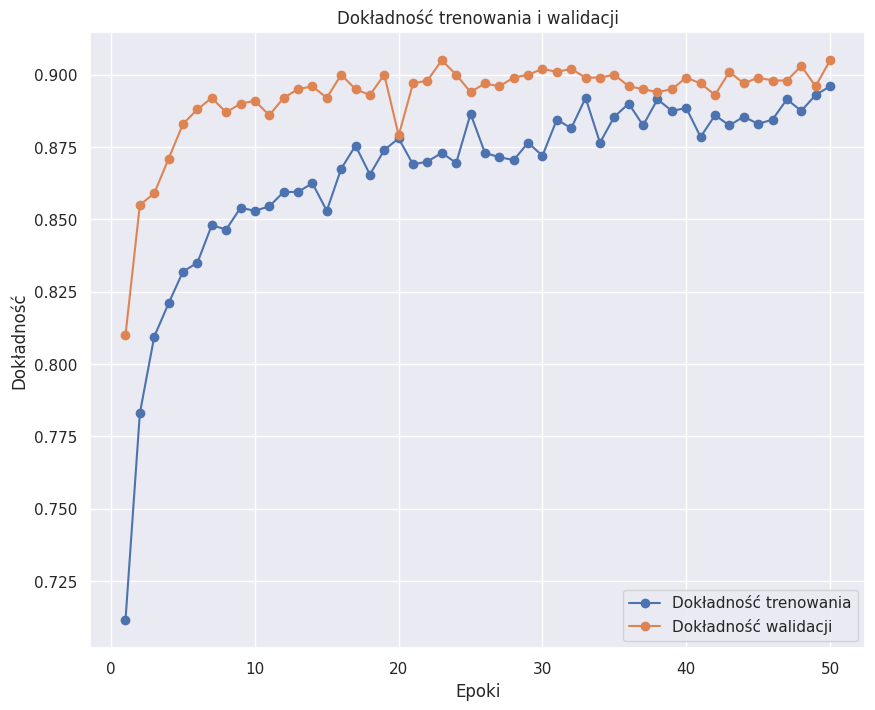

In [33]:
make_accuracy_plot(history)

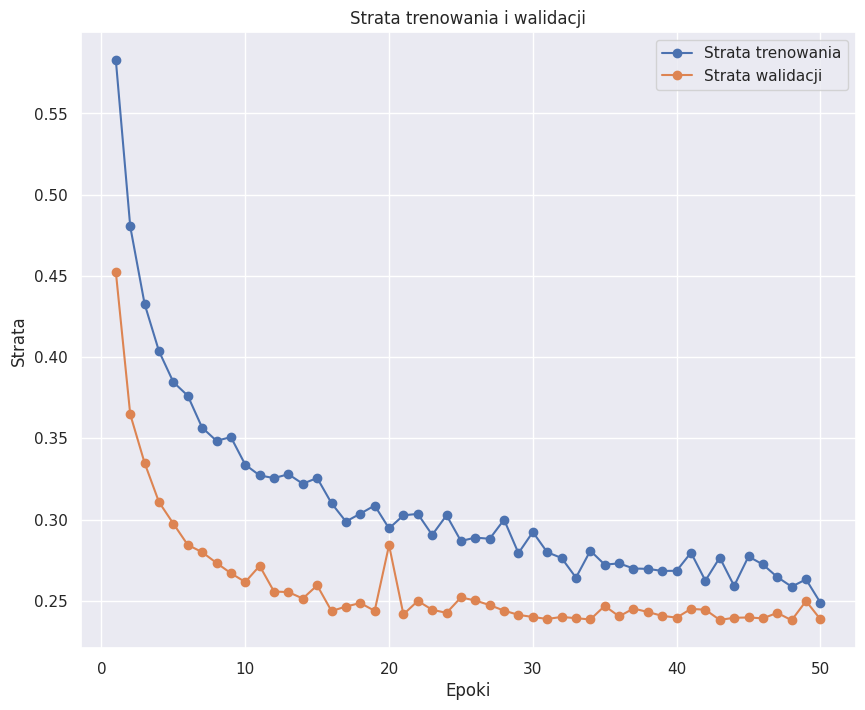

In [34]:
make_loss_plot(history)

Model osiąga dokładność na poziomie 90% co jest nieco lepszym wynikiem niż poprzednio i ulega przeuczeniu po ok. 15-18 epokach. Zwróćmy uwagę na stabilność dokładności na zbiorze walidacyjnym. Zastosowanie Transfer Learningu pozwoliło ograniczyć problem nadmiernego szumu w naszej metryce.

### Dostrajanie

Wcześniejsze warstwy bazy konwolucyjnej uczą się bardziej ogólnych cech (np.krawędzie) zaś wyższe warstwy bardziej wyspecjalizowane cechy. Dzięki temu możemy spróbować poprawić jakość naszgo modelu korzystając z techniki dostrajania.

Technika ta polega na 'odmrożeniu' kilku górnych warstw zamrożonej bazy modelu. Dostroimy trzy ostatnie warstwy konwolucyjne (`block5_conv1, block5_conv2, block5_conv3`).  

In [35]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print('layer_name: {:12}, trainable: {}'.format(layer.name, layer.trainable))

print_layers(conv_base)

layer_name: input_layer_4, trainable: True
layer_name: block1_conv1, trainable: True
layer_name: block1_conv2, trainable: True
layer_name: block1_pool , trainable: True
layer_name: block2_conv1, trainable: True
layer_name: block2_conv2, trainable: True
layer_name: block2_pool , trainable: True
layer_name: block3_conv1, trainable: True
layer_name: block3_conv2, trainable: True
layer_name: block3_conv3, trainable: True
layer_name: block3_pool , trainable: True
layer_name: block4_conv1, trainable: True
layer_name: block4_conv2, trainable: True
layer_name: block4_conv3, trainable: True
layer_name: block4_pool , trainable: True
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [37]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_layer_4, trainable: False
layer_name: block1_conv1, trainable: False
layer_name: block1_conv2, trainable: False
layer_name: block1_pool , trainable: False
layer_name: block2_conv1, trainable: False
layer_name: block2_conv2, trainable: False
layer_name: block2_pool , trainable: False
layer_name: block3_conv1, trainable: False
layer_name: block3_conv2, trainable: False
layer_name: block3_conv3, trainable: False
layer_name: block3_pool , trainable: False
layer_name: block4_conv1, trainable: False
layer_name: block4_conv2, trainable: False
layer_name: block4_conv3, trainable: False
layer_name: block4_pool , trainable: False
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [39]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Trenowanie modelu

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=50)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.6800 - loss: 0.5910 - val_accuracy: 0.8700 - val_loss: 0.3203
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.8389 - loss: 0.3891 - val_accuracy: 0.8970 - val_loss: 0.2541
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.8463 - loss: 0.3262 - val_accuracy: 0.9040 - val_loss: 0.2241
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.8685 - loss: 0.2934 - val_accuracy: 0.9100 - val_loss: 0.2201
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.8794 - loss: 0.2810 - val_accuracy: 0.9210 - val_loss: 0.1892
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.8960 - loss: 0.2493 - val_accuracy: 0.9190 - val_loss: 0.1933
Epoch 7/50
 35/100 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.9349 - loss: 0.1815

In [ ]:
make_accuracy_plot(history)

In [ ]:
make_loss_plot(history)

Model tym razem osiąga dokładność na poziomie 93-94%, co jest znaczną poprawą w stosunku do modelu pierwotnego (ok. 73%). Praktycznie trenowanie moglibyśmy zakończyć po 8-9 epokach, bowiem model póżniej ulega przeuczeniu.

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Dokładność testowania:', test_acc)

## Wizualizacja efektów uczenia sieci konwolucyjnych

*  wizualizacja pośrednich danych wejściowych
*  wizualizacja filtrów sieci konwolucyjnej
*  wizualizacja map ciepła aktywacji klas obrazu

###  Wizualizacja pośrednich danych wejściowych

Polega na wyświetlaniu map cech, które generują się przez różne warstwy konwolucyjne.

In [ ]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

In [ ]:
#@title Wybierz indeks obrazka:
index = 1559 #@param {type:'slider', min:1500, max:1999}
img_path = '/content/cats_and_dogs/test/cats/cat.' + str(index) + '.jpg'

from keras.preprocessing import image
import numpy as np

# przetwarzamy obraz tak aby uzyskał formę czterowymiaorwego tensora
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

In [ ]:
plt.imshow(img_tensor[0])
plt.grid(False)

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

### Wyświetlenie map cech

In [ ]:
plt.figure(figsize=(24, 24))

for i in range(1, 7):
    plt.subplot(1, 6, i)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.grid(False)

### Wizualizacja wszystkich kanałów każdej pośredniej warstwy aktywacji

Pierwsza warstwa wykrywa takie niskopoziomowe elementy jak krawędzie, itd. Na tym etapie aktywacje zachowują prawie wszystkie informacje obecne w wejściowym obrazie. Następne warstwy stają się już coraz bardziej abstrakcyjne i trudniejsze w interpretacji graficznej. Pozwalają one kodować wysokopoziomowe cechy takie jak 'kocie ucho', 'kocie oko'. Wyższe warstwy zawierają coraz mniej informacji dotyczących wizualnej zawartości obrazu i jednocześnie zawierają coraz więcej informacji związanych z klasą obrazu.

In [ ]:
layer_names = [layer.name for layer in model.layers[:8]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row

    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size, row * size: (row+ + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Wizualizacja filtrów konwolucyjnych sieci neuronowych

Filtr konwolucyjny to inaczej graficzny wzorzec na który reaguje podany filtr.


In [ ]:
from keras.applications import VGG16
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss,grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150 , 3))])

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])

    input_img_data += grads_value * step

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
model.summary()

### Wyświetlenie kilku przykładowych fitrów

In [ ]:
#@title Wybierz warstwę:
layer = 'block5_conv1' #@param ['block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']
plt.imshow(generate_pattern(layer, 1))
plt.grid(False)

### Wizualizacje map ciepła aktywacji klas

Na koniec bardzo użyteczna technika wizualizacji. Jest niesłychanie pomocna w procesie debugowania modelu. Pozwala nam stwierdzić na podstawie której części obrazu model podjął taką a nie inną decyzję. Przydatna do eksploracji błędnie sklasyfikowanych obrazów.

W tym celu skorzystamy z implementacji opisanej w artykule [`Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization`](https://arxiv.org/abs/1610.02391).

In [ ]:
#@title Wybierz numer indeksu zdjęcia
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

pets = 'dogs' #@param ['cats', 'dogs']
index = 1748 #@param {'type': 'slider', min :1500, max: 1999}

model = VGG16(weights="imagenet")
img_path = '/content/cats_and_dogs/test/' + pets + '/' + pets[:3] + '.' + str(index) + '.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.imshow(superimposed_img, cmap='viridis')
plt.grid(False)
plt.show()

Obszary zaznaczone na obrazie jako te 'bardziej niebieskie' miały silny wpływ na końcową predykcję modelu. Przykładowo, dla indeksu nr 1748 algorytm bardzo dokładnie wskazał, że przy podejmowaniu decyzji kierował się obszarem obrazu, w którym była zawarta głowa psa (w tym przypadku rasy Husky). Być może tym co pozwoliło zdecydować sieci o kategori obrazu były cechy takie jak kształt/kolor oczu czy kolor sierści wokół oczu.

##Wnioski

*  Konwolucyjne sieci neuronowe są najlepszymi modelami uczenia maszynowego w zadaniach związanych z przetwarzaniem obrazu
*  Sieci konwolucyjne można trenować nawet na małych zbiorach danych, w tym celu pomocna okazuje się augmentacja danych i transfer learning (przykład: zdjęcia medyczne)
*  Możliwość stosowania transfer learningu pozwala trenować modele w znacznie krótszym czasie przy zdecydowanie większej skuteczności takiego modelu wobec modelu opartego tylko na danych, którymi dysponujemy
*  Techniki dostrajania pozwalają przystosować wyuczone wcześniej modele do naszego problemu, co w gruncie rzeczy powinno prowadzić do poprawy skuteczności pracy modelu
* Jak głosi powszechne przekonanie o sieciach neuronowych jako o 'czarnych skrzynkach' to w przypadku sieci konwolucyjnych poszczególne etapy działania sieci są proste w wizualizacji.

> Dzięki zastosowaniu różnych technik optymalizacji modelu (augmentacja danych, transfer learning) z bazowego modelu o poziomie dokładności ok. 73% udało się uzyskać model z dokładnością ok. 93% co jest bardzo zadawalającym wynikiem.

> Projekt można potraktować jako szablon do zadań klasyfikacyjnych obrazu dla klasyfikacji binarnej. Jedyne co należy zmienić to dane wejściowe i niektóre nazwy ścieżek dostępu. Oczywiście, gdy nasze dane będą 'dość duże' można uruchomić klaster obliczeniowy w chmurze, w tym celu polecam narzędzie Amazon SageMaker lub AI Platform udostępniane przez Google Cloud Platform.

